# CNN on CIFAR10 with different optimizers

In [1]:
!pip install wandb==0.9.7
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 8fce5ee4a321acdc93b1ab718535a737dc60ad84
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


## Import libraries

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image

import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Load dataset

In [3]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 100, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [5]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst_train = []
    loss_lst_train = []
    accuracy_lst_val = []
    loss_lst_val = []
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        model.train()
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst_train.append((correct/num_labels).cpu().item())
        loss_lst_train.append(total_loss/counter)

        # Validation
        model.eval()
        total_loss_val = 0
        correct_val = 0
        num_labels_val = 0
        counter_val = 0
        model.eval()
        for batch_idx, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)

            output = model(X)

            loss = loss_func(output, y)
            total_loss_val += loss.item()

            predicted = torch.max(output,1)[1]
            correct_val += (predicted == y).sum()
            num_labels_val += len(y)
            counter_val += 1
        loss_lst_val.append(total_loss_val/counter_val)
        accuracy_lst_val.append((correct_val/num_labels_val).cpu().item())

        # Log
        wandb.log({'Training Accuracy': accuracy_lst_train[-1], 'Training Loss': loss_lst_train[-1], 'Testing Accuracy': accuracy_lst_val[-1], 'Testing Loss': loss_lst_val[-1]})

        print('Epoch %d, Training Loss %4f, Training Accuracy %4f, Testing Loss %4f, Testing Accuracy %4f'
            % (epoch+1, total_loss/counter, correct/num_labels, total_loss_val/counter_val, correct_val/num_labels_val))
    return accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val

## Training

In [6]:
lr = 0.001

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=100, bias=False)
)


In [7]:
num_epoch = 100

In [8]:

optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.95, weight_decay=5e-4)
SGD_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='SGDM')
wandb.watch(model, log="all", log_freq=10)
accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)

#SGD_run.finish()

wandb: Wandb version 0.13.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/196 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1, Training Loss 1.724400, Training Accuracy 0.395000, Testing Loss 1.391063, Testing Accuracy 0.507000


Epoch 2/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 1.387206, Training Accuracy 0.504300, Testing Loss 1.382553, Testing Accuracy 0.514400


Epoch 3/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 1.264119, Training Accuracy 0.549840, Testing Loss 1.315939, Testing Accuracy 0.547600


Epoch 4/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 1.189734, Training Accuracy 0.579400, Testing Loss 1.224217, Testing Accuracy 0.575300


Epoch 5/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 1.140525, Training Accuracy 0.598680, Testing Loss 1.412224, Testing Accuracy 0.546400


Epoch 6/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 1.095359, Training Accuracy 0.615760, Testing Loss 1.045257, Testing Accuracy 0.636100


Epoch 7/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 1.045504, Training Accuracy 0.634980, Testing Loss 1.004150, Testing Accuracy 0.650300


Epoch 8/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 1.024535, Training Accuracy 0.642340, Testing Loss 1.105033, Testing Accuracy 0.615400


Epoch 9/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.993499, Training Accuracy 0.653320, Testing Loss 1.321595, Testing Accuracy 0.569300


Epoch 10/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.977096, Training Accuracy 0.660680, Testing Loss 0.977433, Testing Accuracy 0.659000


Epoch 11/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.957442, Training Accuracy 0.667240, Testing Loss 0.904951, Testing Accuracy 0.685700


Epoch 12/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.937697, Training Accuracy 0.674200, Testing Loss 1.096927, Testing Accuracy 0.620500


Epoch 13/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.915399, Training Accuracy 0.681060, Testing Loss 0.880903, Testing Accuracy 0.691400


Epoch 14/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.899746, Training Accuracy 0.688020, Testing Loss 0.848492, Testing Accuracy 0.703300


Epoch 15/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.887119, Training Accuracy 0.692460, Testing Loss 0.960448, Testing Accuracy 0.666100


Epoch 16/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.874943, Training Accuracy 0.697940, Testing Loss 0.895435, Testing Accuracy 0.690900


Epoch 17/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.855576, Training Accuracy 0.705080, Testing Loss 0.864842, Testing Accuracy 0.697100


Epoch 18/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.845962, Training Accuracy 0.707840, Testing Loss 0.981154, Testing Accuracy 0.651100


Epoch 19/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.842787, Training Accuracy 0.707840, Testing Loss 0.985129, Testing Accuracy 0.661300


Epoch 20/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.827968, Training Accuracy 0.713840, Testing Loss 0.871445, Testing Accuracy 0.690700


Epoch 21/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.823692, Training Accuracy 0.716180, Testing Loss 1.009991, Testing Accuracy 0.646000


Epoch 22/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.811553, Training Accuracy 0.721580, Testing Loss 0.762701, Testing Accuracy 0.737700


Epoch 23/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.803951, Training Accuracy 0.721940, Testing Loss 0.843744, Testing Accuracy 0.714700


Epoch 24/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.798738, Training Accuracy 0.724280, Testing Loss 0.772577, Testing Accuracy 0.729700


Epoch 25/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.791087, Training Accuracy 0.726200, Testing Loss 0.807640, Testing Accuracy 0.726700


Epoch 26/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.776672, Training Accuracy 0.733000, Testing Loss 0.769809, Testing Accuracy 0.728700


Epoch 27/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.777495, Training Accuracy 0.732840, Testing Loss 0.787597, Testing Accuracy 0.724000


Epoch 28/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.765707, Training Accuracy 0.738280, Testing Loss 0.829904, Testing Accuracy 0.721200


Epoch 29/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.754051, Training Accuracy 0.740060, Testing Loss 0.809307, Testing Accuracy 0.716800


Epoch 30/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.757766, Training Accuracy 0.739840, Testing Loss 0.805743, Testing Accuracy 0.725900


Epoch 31/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.754836, Training Accuracy 0.739740, Testing Loss 0.918424, Testing Accuracy 0.694300


Epoch 32/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.743146, Training Accuracy 0.742480, Testing Loss 0.766613, Testing Accuracy 0.732100


Epoch 33/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.739305, Training Accuracy 0.745140, Testing Loss 0.751665, Testing Accuracy 0.739200


Epoch 34/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.726795, Training Accuracy 0.751940, Testing Loss 0.744025, Testing Accuracy 0.746300


Epoch 35/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.726263, Training Accuracy 0.749200, Testing Loss 0.775141, Testing Accuracy 0.730500


Epoch 36/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.721084, Training Accuracy 0.750480, Testing Loss 0.885875, Testing Accuracy 0.695700


Epoch 37/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.721448, Training Accuracy 0.753400, Testing Loss 0.758997, Testing Accuracy 0.739400


Epoch 38/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.709581, Training Accuracy 0.757660, Testing Loss 0.747752, Testing Accuracy 0.741600


Epoch 39/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.711338, Training Accuracy 0.757020, Testing Loss 0.703965, Testing Accuracy 0.760400


Epoch 40/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.707280, Training Accuracy 0.757240, Testing Loss 0.705318, Testing Accuracy 0.757400


Epoch 41/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Training Loss 0.698446, Training Accuracy 0.759660, Testing Loss 0.686090, Testing Accuracy 0.765600


Epoch 42/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Training Loss 0.699191, Training Accuracy 0.759060, Testing Loss 0.832938, Testing Accuracy 0.717500


Epoch 43/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Training Loss 0.695117, Training Accuracy 0.760820, Testing Loss 0.703362, Testing Accuracy 0.753100


Epoch 44/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Training Loss 0.684375, Training Accuracy 0.765400, Testing Loss 0.709489, Testing Accuracy 0.757600


Epoch 45/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Training Loss 0.689008, Training Accuracy 0.764120, Testing Loss 0.701943, Testing Accuracy 0.757900


Epoch 46/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Training Loss 0.681452, Training Accuracy 0.767760, Testing Loss 0.801231, Testing Accuracy 0.731000


Epoch 47/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Training Loss 0.681203, Training Accuracy 0.767340, Testing Loss 0.717141, Testing Accuracy 0.749500


Epoch 48/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Training Loss 0.675476, Training Accuracy 0.767960, Testing Loss 0.695383, Testing Accuracy 0.759900


Epoch 49/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Training Loss 0.674447, Training Accuracy 0.769080, Testing Loss 0.950676, Testing Accuracy 0.689000


Epoch 50/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Training Loss 0.670303, Training Accuracy 0.768820, Testing Loss 0.664646, Testing Accuracy 0.774000


Epoch 51/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Training Loss 0.663622, Training Accuracy 0.771500, Testing Loss 0.726711, Testing Accuracy 0.753800


Epoch 52/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Training Loss 0.663607, Training Accuracy 0.774040, Testing Loss 0.726266, Testing Accuracy 0.748000


Epoch 53/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Training Loss 0.668055, Training Accuracy 0.771820, Testing Loss 0.664557, Testing Accuracy 0.774200


Epoch 54/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Training Loss 0.659071, Training Accuracy 0.773860, Testing Loss 0.651817, Testing Accuracy 0.776200


Epoch 55/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Training Loss 0.653063, Training Accuracy 0.777280, Testing Loss 0.713779, Testing Accuracy 0.754500


Epoch 56/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Training Loss 0.646798, Training Accuracy 0.780920, Testing Loss 0.623031, Testing Accuracy 0.782800


Epoch 57/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Training Loss 0.646507, Training Accuracy 0.777200, Testing Loss 0.634123, Testing Accuracy 0.785600


Epoch 58/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Training Loss 0.649793, Training Accuracy 0.776920, Testing Loss 0.642461, Testing Accuracy 0.780700


Epoch 59/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Training Loss 0.645294, Training Accuracy 0.781180, Testing Loss 0.762873, Testing Accuracy 0.739900


Epoch 60/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60, Training Loss 0.645625, Training Accuracy 0.777220, Testing Loss 0.702541, Testing Accuracy 0.755800


Epoch 61/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61, Training Loss 0.637116, Training Accuracy 0.780620, Testing Loss 0.706828, Testing Accuracy 0.764600


Epoch 62/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62, Training Loss 0.641538, Training Accuracy 0.778520, Testing Loss 0.721229, Testing Accuracy 0.749800


Epoch 63/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63, Training Loss 0.635832, Training Accuracy 0.782620, Testing Loss 0.661169, Testing Accuracy 0.774100


Epoch 64/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64, Training Loss 0.630738, Training Accuracy 0.782660, Testing Loss 0.685026, Testing Accuracy 0.765600


Epoch 65/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65, Training Loss 0.629982, Training Accuracy 0.784580, Testing Loss 0.722189, Testing Accuracy 0.750500


Epoch 66/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66, Training Loss 0.628848, Training Accuracy 0.784260, Testing Loss 0.889848, Testing Accuracy 0.704800


Epoch 67/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67, Training Loss 0.623643, Training Accuracy 0.786440, Testing Loss 0.677835, Testing Accuracy 0.766100


Epoch 68/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68, Training Loss 0.619927, Training Accuracy 0.786300, Testing Loss 0.658931, Testing Accuracy 0.768200


Epoch 69/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69, Training Loss 0.620950, Training Accuracy 0.786200, Testing Loss 0.663691, Testing Accuracy 0.777900


Epoch 70/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70, Training Loss 0.615743, Training Accuracy 0.789500, Testing Loss 0.618792, Testing Accuracy 0.785300


Epoch 71/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71, Training Loss 0.618855, Training Accuracy 0.786400, Testing Loss 0.797102, Testing Accuracy 0.723900


Epoch 72/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72, Training Loss 0.620719, Training Accuracy 0.786960, Testing Loss 0.895902, Testing Accuracy 0.710200


Epoch 73/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73, Training Loss 0.614885, Training Accuracy 0.790040, Testing Loss 0.739213, Testing Accuracy 0.742600


Epoch 74/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74, Training Loss 0.614804, Training Accuracy 0.788580, Testing Loss 0.709293, Testing Accuracy 0.759700


Epoch 75/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75, Training Loss 0.611479, Training Accuracy 0.791080, Testing Loss 0.761279, Testing Accuracy 0.744400


Epoch 76/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76, Training Loss 0.610547, Training Accuracy 0.790880, Testing Loss 0.717049, Testing Accuracy 0.755900


Epoch 77/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77, Training Loss 0.603775, Training Accuracy 0.791860, Testing Loss 0.636737, Testing Accuracy 0.782700


Epoch 78/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78, Training Loss 0.611185, Training Accuracy 0.789760, Testing Loss 0.828184, Testing Accuracy 0.719900


Epoch 79/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79, Training Loss 0.598223, Training Accuracy 0.795840, Testing Loss 0.727726, Testing Accuracy 0.755700


Epoch 80/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80, Training Loss 0.601315, Training Accuracy 0.793600, Testing Loss 0.640503, Testing Accuracy 0.782800


Epoch 81/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81, Training Loss 0.602624, Training Accuracy 0.793660, Testing Loss 0.654854, Testing Accuracy 0.776400


Epoch 82/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82, Training Loss 0.598555, Training Accuracy 0.794920, Testing Loss 0.679174, Testing Accuracy 0.772100


Epoch 83/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83, Training Loss 0.604852, Training Accuracy 0.790860, Testing Loss 0.608292, Testing Accuracy 0.792300


Epoch 84/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84, Training Loss 0.596930, Training Accuracy 0.792980, Testing Loss 0.602887, Testing Accuracy 0.792200


Epoch 85/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85, Training Loss 0.598164, Training Accuracy 0.794380, Testing Loss 0.610278, Testing Accuracy 0.792700


Epoch 86/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86, Training Loss 0.592875, Training Accuracy 0.798000, Testing Loss 0.693317, Testing Accuracy 0.765300


Epoch 87/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87, Training Loss 0.592754, Training Accuracy 0.795020, Testing Loss 0.661370, Testing Accuracy 0.774900


Epoch 88/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88, Training Loss 0.586004, Training Accuracy 0.799780, Testing Loss 0.634002, Testing Accuracy 0.781400


Epoch 89/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89, Training Loss 0.597971, Training Accuracy 0.793960, Testing Loss 0.635162, Testing Accuracy 0.781600


Epoch 90/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90, Training Loss 0.591161, Training Accuracy 0.796700, Testing Loss 0.696201, Testing Accuracy 0.762000


Epoch 91/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91, Training Loss 0.590562, Training Accuracy 0.796700, Testing Loss 0.617301, Testing Accuracy 0.783200


Epoch 92/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92, Training Loss 0.588140, Training Accuracy 0.799440, Testing Loss 0.802012, Testing Accuracy 0.738600


Epoch 93/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93, Training Loss 0.578719, Training Accuracy 0.802820, Testing Loss 0.656156, Testing Accuracy 0.777900


Epoch 94/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94, Training Loss 0.582296, Training Accuracy 0.799880, Testing Loss 0.669658, Testing Accuracy 0.769800


Epoch 95/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95, Training Loss 0.582100, Training Accuracy 0.800840, Testing Loss 0.610233, Testing Accuracy 0.794800


Epoch 96/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96, Training Loss 0.585239, Training Accuracy 0.797880, Testing Loss 0.680991, Testing Accuracy 0.768200


Epoch 97/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97, Training Loss 0.579693, Training Accuracy 0.800100, Testing Loss 0.612570, Testing Accuracy 0.791400


Epoch 98/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98, Training Loss 0.580033, Training Accuracy 0.800720, Testing Loss 0.699464, Testing Accuracy 0.768800


Epoch 99/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99, Training Loss 0.575675, Training Accuracy 0.801660, Testing Loss 0.674021, Testing Accuracy 0.767700


Epoch 100/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100, Training Loss 0.572269, Training Accuracy 0.805760, Testing Loss 0.695308, Testing Accuracy 0.762700


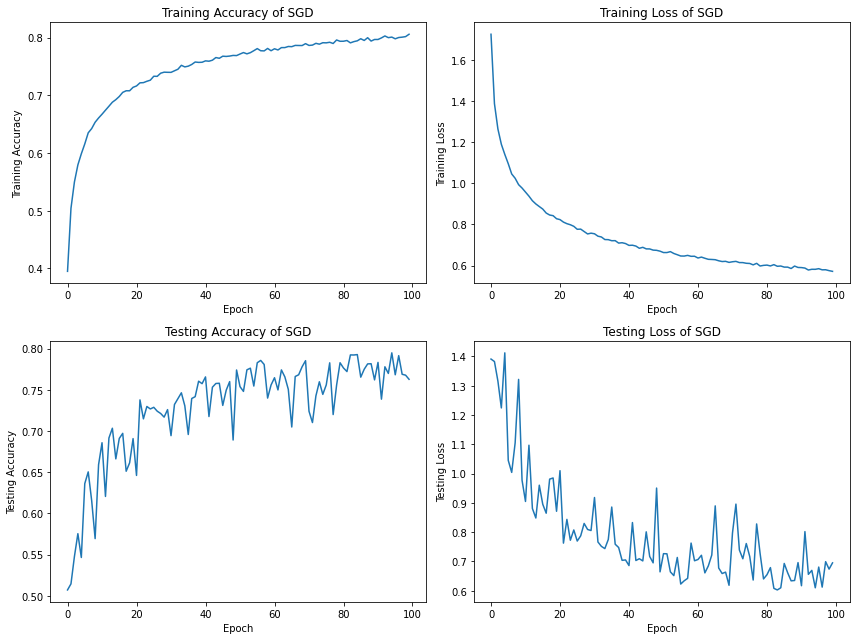

In [9]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of SGD')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of SGD')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of SGD')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of SGD')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()